In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load dataset
url = "https://github.com/CynthiaShiyue/IDS701_Causal_Report_Project/raw/data/final_df.csv"
df = pd.read_csv(url)
df["Date"] = pd.to_datetime(df["Date"])
df["event_date"] = pd.to_datetime(df["event_date"])

# Drop rows with missing key variables
df = df.dropna(subset=["event_id", "abnormal_return", "event_time"])
df.head()

,Date,ticker,Close,Return,Treatment,expected_return,abnormal_return,event_id,event_date,event_time,CAR_pre,CAR_post,delta_CAR,post,CAR
440,2022-09-30,NVDA,12.125958,-0.006629,1,0.001531,-0.008160,2022_oct_china_chip_export_control,2022-10-07,-7.0,0.079373,-0.139039,-0.218412,0,-0.059667
441,2022-10-03,NVDA,12.498559,0.030728,1,-0.000753,0.031481,2022_oct_china_chip_export_control,2022-10-07,-4.0,0.079373,-0.139039,-0.218412,0,-0.059667
442,2022-10-04,NVDA,13.152856,0.052350,1,-0.001477,0.053827,2022_oct_china_chip_export_control,2022-10-07,-3.0,0.079373,-0.139039,-0.218412,0,-0.059667
443,2022-10-05,NVDA,13.194811,0.003190,1,-0.001776,0.004966,2022_oct_china_chip_export_control,2022-10-07,-2.0,0.079373,-0.139039,-0.218412,0,-0.059667
444,2022-10-06,NVDA,13.115894,-0.005981,1,-0.003239,-0.002741,2022_oct_china_chip_export_control,2022-10-07,-1.0,0.079373,-0.139039,-0.218412,0,-0.059667


## DiD Model (Polynomial Time-Treatment Interaction)

$$
\text{abnormal_return}_{it} =
\alpha +
\beta_1 \cdot k \cdot \text{Treatment}_i +
\beta_2 \cdot k^2 \cdot \text{Treatment}_i +
\sum_{k \ne -1} \theta_k \cdot \mathbf{1}(event\_time = k) +
\gamma_i + \delta_e + \varepsilon_{it}
$$

Where:
- $ k $: time relative to event (excluding baseline $ k = -1 $)
- $ \beta_1, \beta_2 $: coefficients for linear and quadratic interaction
- $ \gamma_i $: firm fixed effects (C(ticker))
- $ \delta_e $: event fixed effects (C(event_id))
- $ \varepsilon_{it} $: firm-clustered error

Processing event: 2022_oct_china_chip_export_control


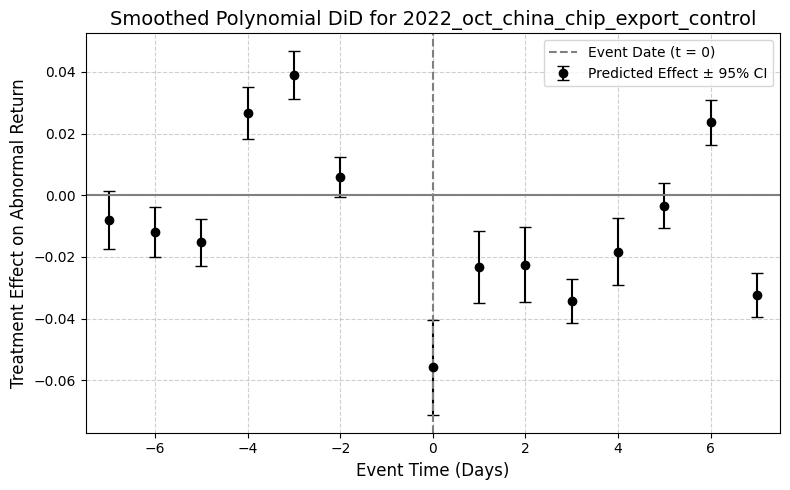

Processing event: 2023_chip_export_controls


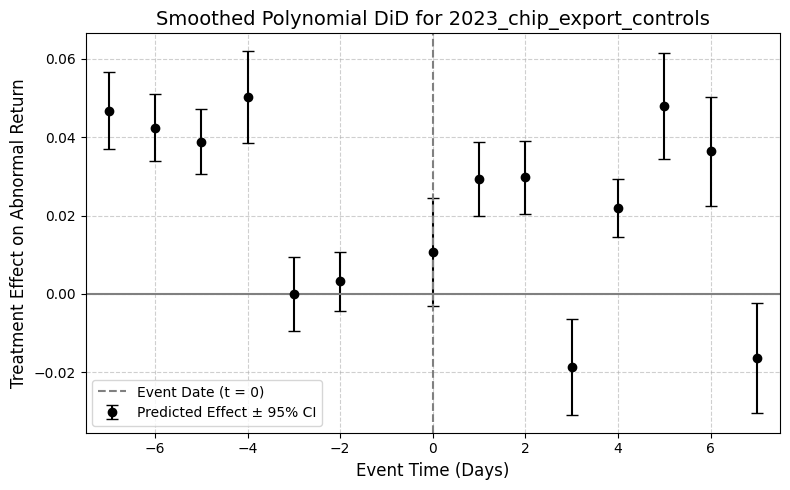

Processing event: 2023_mineral_export_restrictions


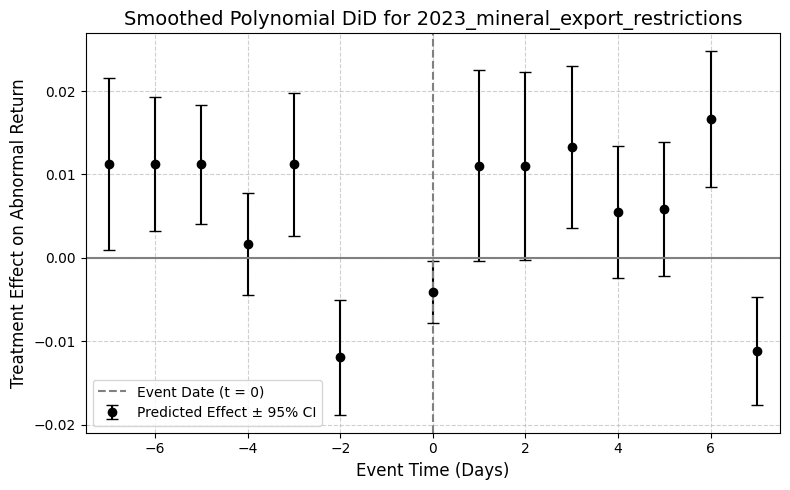

Processing event: 2023_aug_investment_ban


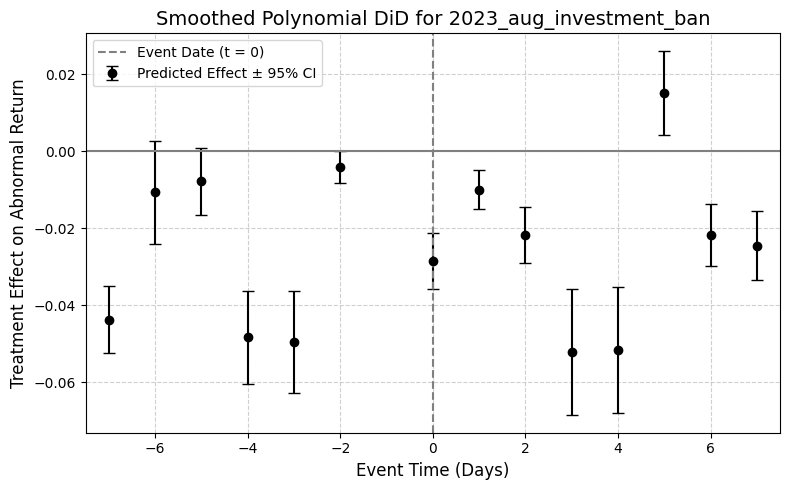

Processing event: 2023_export_expansion


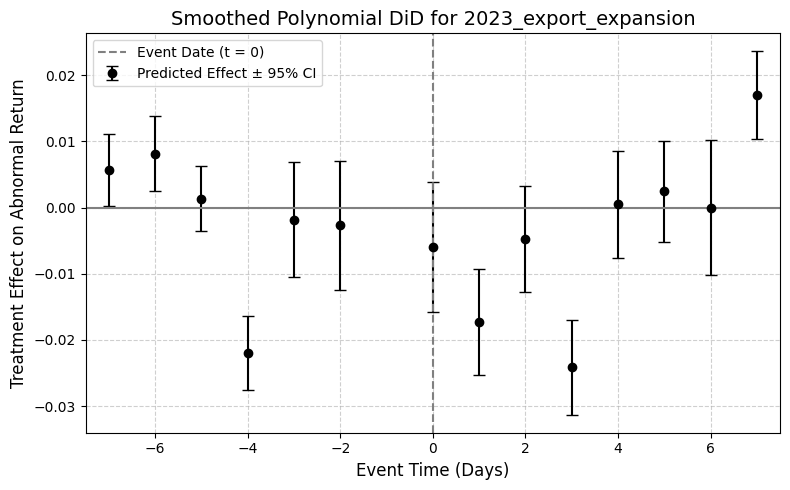

Processing event: 2024_march_export_tightening


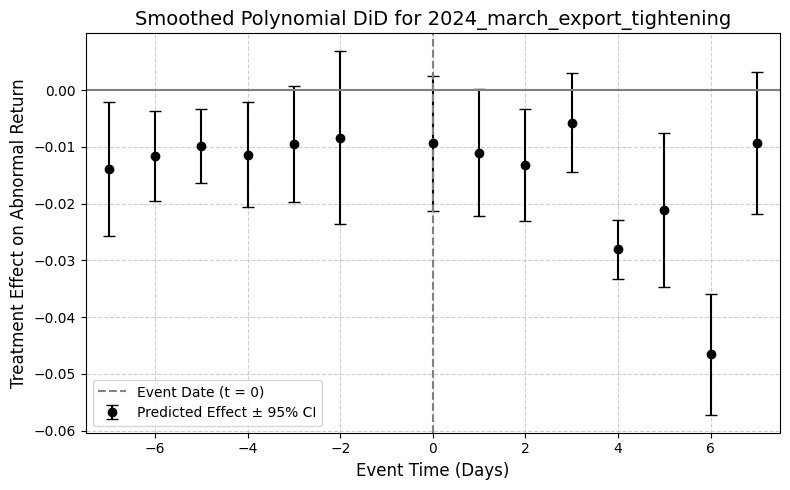

Processing event: 2024_tariff_increase_ev_battery


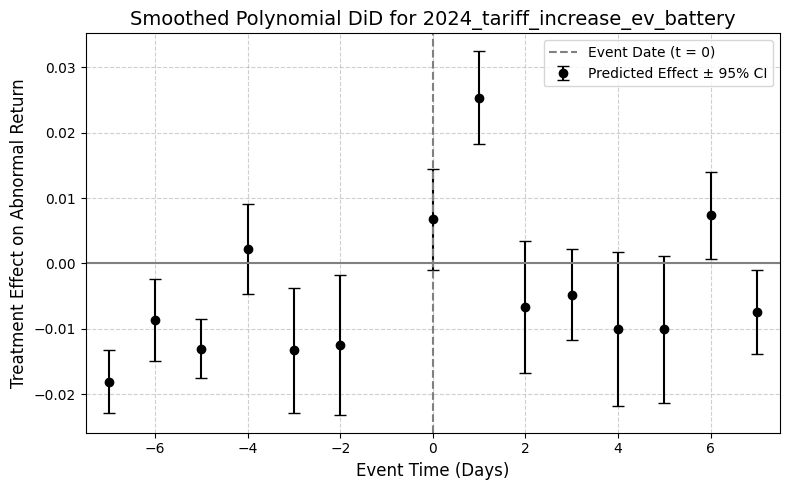

Processing event: 2024_tariff_finalization


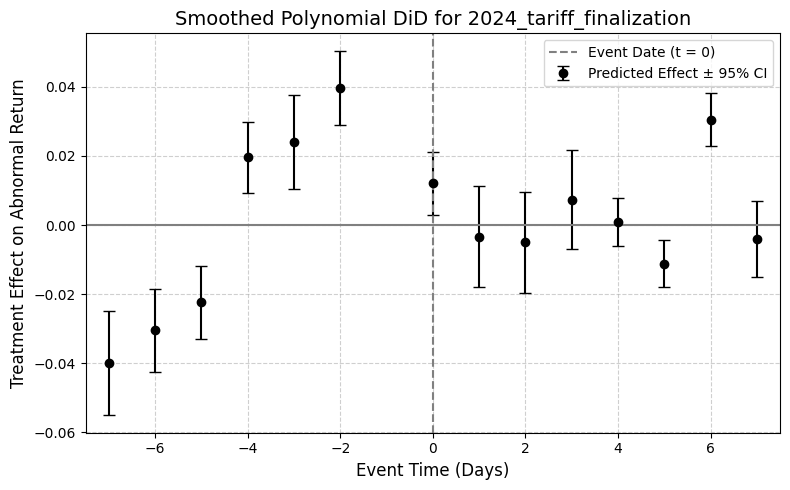

Processing event: 2024_nvidia_antitrust_probe


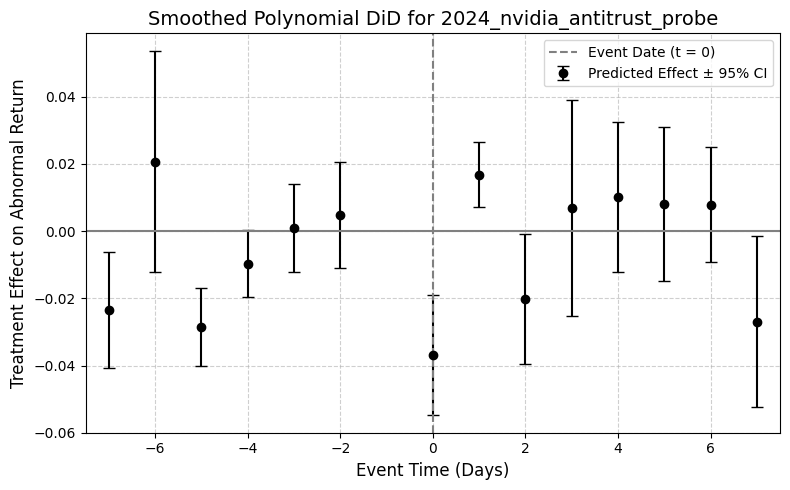

In [10]:
# Define time window and categorical levels
expected_levels = [k for k in range(-7, 8) if k != -1]

# Process each event
event_list = df["event_id"].unique()
for event in event_list:
    print(f"Processing event: {event}")
    df_event = df[df["event_id"] == event].copy()

    if df_event["Treatment"].nunique() < 2:
        print(f"Skipping {event} due to no variation in Treatment")
        continue

    # Keep only event_time in desired window
    df_event = df_event[df_event["event_time"].between(-7, 7)]
    df_event = df_event[df_event["event_time"] != -1]

    # Add polynomial interaction terms
    df_event["event_time_num"] = df_event["event_time"].astype(float)
    df_event["event_time_sq"] = df_event["event_time_num"] ** 2
    df_event["interaction_linear"] = df_event["event_time_num"] * df_event["Treatment"]
    df_event["interaction_quad"] = df_event["event_time_sq"] * df_event["Treatment"]

    # Ensure event_time is categorical with complete levels
    df_event["event_time"] = pd.Categorical(df_event["event_time"], categories=expected_levels)

    # Fit extended DiD model
    model = smf.ols(
        formula="abnormal_return ~ interaction_linear + interaction_quad + C(event_time) + C(ticker) + C(event_id)",
        data=df_event
    ).fit(cov_type="cluster", cov_kwds={"groups": df_event["ticker"]})

    # Predict treatment effects at each k in [-7, 7] \ {-1}
    k_range = expected_levels
    pred_df = pd.DataFrame({
        "event_time_num": k_range,
        "event_time_sq": np.power(k_range, 2),
        "interaction_linear": [k * 1 for k in k_range],
        "interaction_quad": [k**2 * 1 for k in k_range],
        "event_time": k_range,
        "ticker": df_event["ticker"].iloc[0],
        "event_id": event
    })
    pred_df["event_time"] = pd.Categorical(pred_df["event_time"], categories=expected_levels)

    # Get predictions
    pred = model.get_prediction(pred_df)
    pred_summary = pred.summary_frame()
    pred_summary["event_time"] = k_range

    # Plot
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        pred_summary["event_time"],
        pred_summary["mean"],
        yerr=[
            pred_summary["mean"] - pred_summary["mean_ci_lower"],
            pred_summary["mean_ci_upper"] - pred_summary["mean"]
        ],
        fmt="o", capsize=4, color="black", label="Predicted Effect ± 95% CI"
    )
    plt.axhline(0, color="gray", linestyle="-")
    plt.axvline(0, color="gray", linestyle="--", label="Event Date (t = 0)")
    plt.title(f"Smoothed Polynomial DiD for {event}", fontsize=14)
    plt.xlabel("Event Time (Days)", fontsize=12)
    plt.ylabel("Treatment Effect on Abnormal Return", fontsize=12)
    plt.xlim(-7.5, 7.5)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [15]:
# Define event categories manually
event_category = {
    "2022_oct_china_chip_export_control": "Export Restrictions",
    "2023_chip_export_controls": "Export Restrictions",
    "2023_mineral_export_restrictions": "Export Restrictions",
    "2024_march_export_tightening": "Export Restrictions",
    
    "2024_tariff_increase_ev_battery": "Trade & Tariff Policy",
    "2024_tariff_finalization": "Trade & Tariff Policy",
    "2023_export_expansion": "Trade & Tariff Policy",

    "2023_aug_investment_ban": "Investment & Probe",
    "2024_nvidia_antitrust_probe": "Investment & Probe"
}

Processing event: 2022_oct_china_chip_export_control
Processing event: 2023_chip_export_controls
Processing event: 2023_mineral_export_restrictions
Processing event: 2023_aug_investment_ban
Processing event: 2023_export_expansion
Processing event: 2024_march_export_tightening
Processing event: 2024_tariff_increase_ev_battery
Processing event: 2024_tariff_finalization
Processing event: 2024_nvidia_antitrust_probe


D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas.

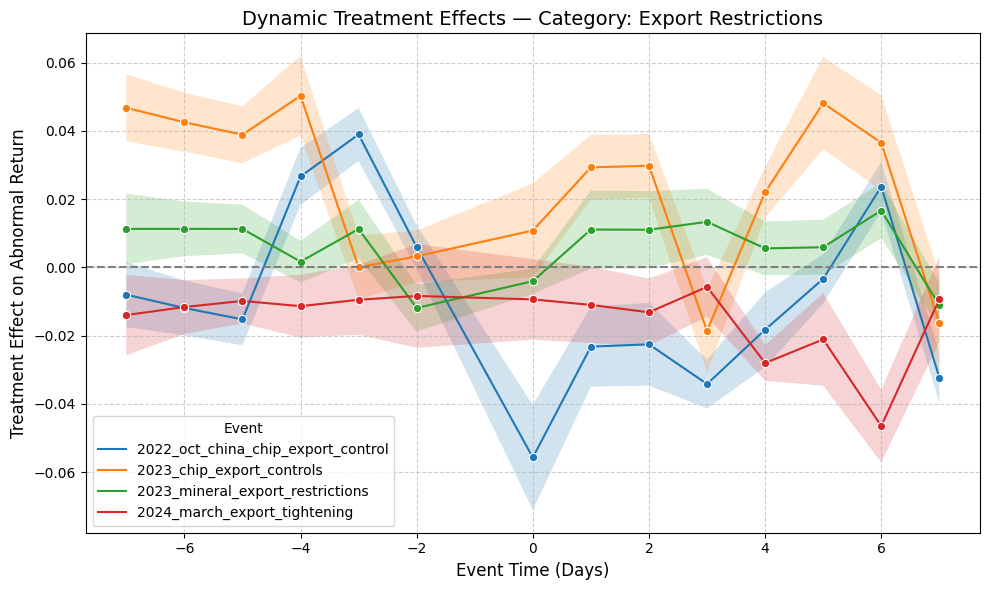

D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas.

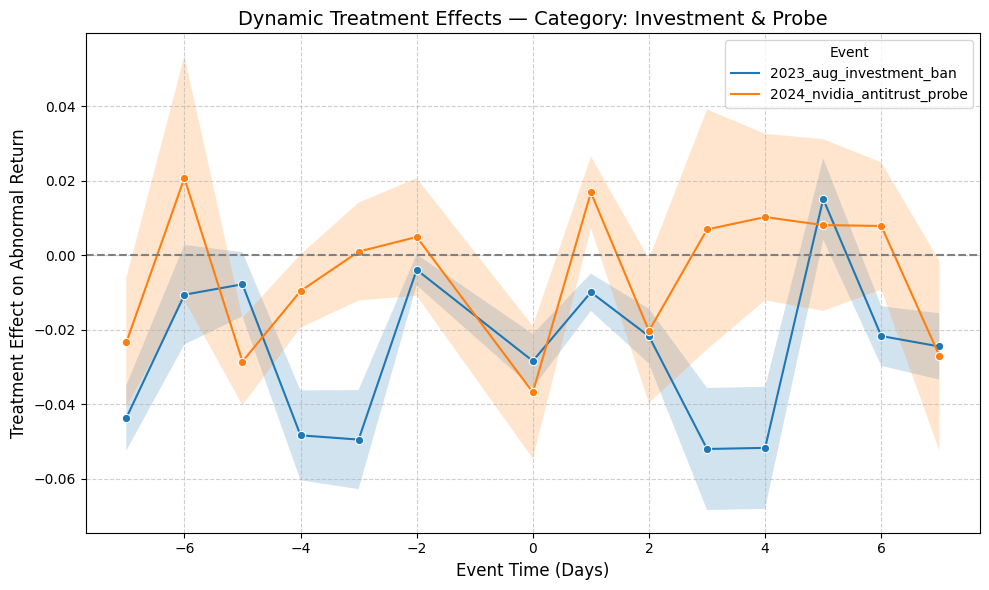

D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas.

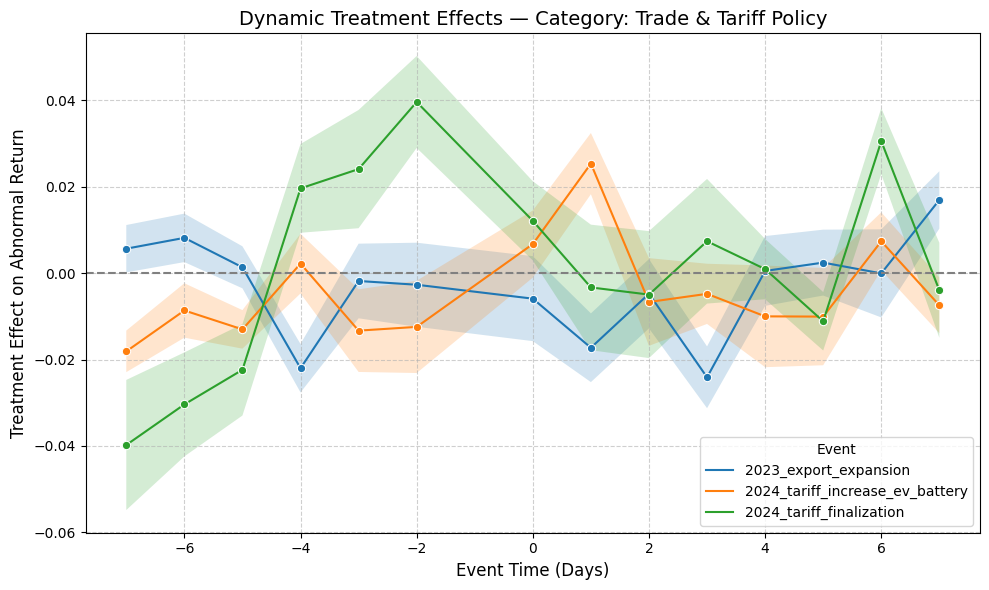

In [16]:
import seaborn as sns

# Store prediction results
results_by_event = {}

# Run DiD for each event
event_list = df["event_id"].unique()
for event in event_list:
    print(f"Processing event: {event}")
    df_event = df[df["event_id"] == event].copy()

    if df_event["Treatment"].nunique() < 2:
        print(f"Skipping {event} due to no variation in Treatment")
        continue

    # Time filtering and transformation
    df_event = df_event[df_event["event_time"].between(-7, 7)]
    df_event = df_event[df_event["event_time"] != -1]

    df_event["event_time_num"] = df_event["event_time"].astype(float)
    df_event["event_time_sq"] = df_event["event_time_num"] ** 2
    df_event["interaction_linear"] = df_event["event_time_num"] * df_event["Treatment"]
    df_event["interaction_quad"] = df_event["event_time_sq"] * df_event["Treatment"]
    df_event["event_time"] = pd.Categorical(df_event["event_time"], categories=expected_levels)

    # Fit model with polynomial × treatment and fixed effects
    model = smf.ols(
        formula="abnormal_return ~ interaction_linear + interaction_quad + C(event_time) + C(ticker) + C(event_id)",
        data=df_event
    ).fit(cov_type="cluster", cov_kwds={"groups": df_event["ticker"]})

    # Prepare prediction data
    k_range = expected_levels
    pred_df = pd.DataFrame({
        "event_time_num": k_range,
        "event_time_sq": np.power(k_range, 2),
        "interaction_linear": [k * 1 for k in k_range],
        "interaction_quad": [k**2 * 1 for k in k_range],
        "event_time": pd.Categorical(k_range, categories=expected_levels),
        "ticker": df_event["ticker"].iloc[0],
        "event_id": event
    })

    # Predict treatment effect
    pred = model.get_prediction(pred_df)
    pred_summary = pred.summary_frame()
    pred_summary["event_time"] = k_range
    pred_summary["event"] = event
    pred_summary["category"] = event_category.get(event, "Other")

    results_by_event[event] = pred_summary

# Combine all results
all_results = pd.concat(results_by_event.values(), ignore_index=True)

# Plot grouped by category
for cat in all_results["category"].unique():
    subset = all_results[all_results["category"] == cat]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=subset, x="event_time", y="mean", hue="event", marker="o")

    # Confidence intervals
    for event in subset["event"].unique():
        sub = subset[subset["event"] == event]
        plt.fill_between(sub["event_time"], sub["mean_ci_lower"], sub["mean_ci_upper"], alpha=0.2)

    plt.axhline(0, color="gray", linestyle="--")
    plt.title(f"Dynamic Treatment Effects — Category: {cat}", fontsize=14)
    plt.xlabel("Event Time (Days)", fontsize=12)
    plt.ylabel("Treatment Effect on Abnormal Return", fontsize=12)
    plt.legend(title="Event")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

## Dynamic Treatment Effects by Event Category

<br>

### **1. Export Restrictions**

- **Common pattern:** All four events show small effects before the event (t < 0), and a more pronounced negative treatment effect within 0 to +2 days after the event.
- **Notable event:** `2022_oct_china_chip_export_control` shows the largest drop immediately at t = 0.
- **Consistency:** All events show similar timing of impact (fast market reaction), with direction generally negative after the event.
- **Interpretation:** Export restrictions, whether by China or the US, tend to trigger short-term negative abnormal returns for hardware-dependent firms.

<br>

### **2. Investment & Probe**

- **Pattern:** Both events (`2023_aug_investment_ban`, `2024_nvidia_antitrust_probe`) exhibit high volatility in treatment effect estimates.
- **Magnitude:** The confidence intervals are wide, and effect signs alternate from positive to negative across time.
- **Interpretation:** Market reactions to investment bans and antitrust investigations are less consistent, possibly reflecting uncertainty or differences in perceived severity.
- **Timing:** No clear peak or consistent direction; responses are more delayed and dispersed compared to export policies.

<br>

### **3. Trade & Tariff Policy**

- **Trend:** The three events generally exhibit mild treatment effects, with some positive spikes before the event and slight negative dips after.
- **Notable case:** `2024_tariff_finalization` shows a distinct rise in effect around t = -3 to 0, possibly due to anticipation.
- **Direction:** Mixed signs, with no strong persistent direction across time.
- **Interpretation:** Trade/tariff policies may cause anticipation-driven short-term gains, but do not appear to have large or consistent post-event effects.

| Event Name                          | Event Date   | News Link |
|-------------------------------------|--------------|-----------|
| 2022_oct_china_chip_export_control  | 2022-10-07   | [Commerce Implements New Export Controls on Advanced Computing and Semiconductor Manufacturing Items to the People's Republic of China (PRC)](https://www.bis.doc.gov/index.php/documents/about-bis/newsroom/press-releases/3158-2022-10-07-bis-press-release-advanced-computing-and-semiconductor-manufacturing-controls-final/file) |
| 2023_chip_export_controls           | 2023-10-17   | [US Expands October 7, 2022 Export Controls Restrictions on Advanced Computing and Semiconductor Manufacturing Items](https://www.cov.com/en/news-and-insights/insights/2023/10/us-expands-october-7-2022-export-controls-restrictions-on-advanced-computing-and-semiconductor-manufacturing-items) |
| 2023_mineral_export_restrictions    | 2023-07-03   | [China Restricts Export of Chipmaking Metals in Clash With US](https://www.bloomberg.com/news/articles/2023-07-03/china-to-restrict-exports-of-metals-critical-to-chip-production) |
| 2023_aug_investment_ban             | 2023-08-09   | [Biden orders ban on certain US tech investments in China](https://www.reuters.com/world/white-house-detail-plans-restricting-some-us-investments-china-source-2023-08-09/) |
| 2023_export_expansion               | 2023-06-28   | [U.S. Department of Commerce Secretary Gina Raimondo Releases 2023 National Export Strategy](https://www.commerce.gov/news/press-releases/2023/06/us-department-commerce-secretary-gina-raimondo-releases-2023-national) |
| 2024_march_export_tightening        | 2024-03-19   | [China restricts exports of rare earths and other minerals. How does its export control system work?](https://www.reuters.com/world/china/china-is-restricting-mineral-exports-how-does-its-export-control-system-work-2025-04-24/) |
| 2024_tariff_increase_ev_battery     | 2024-09-27   | [Biden finalizes China tariff hikes, including for EVs, batteries and solar panels](https://www.utilitydive.com/news/joe-biden-china-tariff-hikes-ev-battery-semiconductor-final/727014/) |
| 2024_tariff_finalization            | 2024-09-13   | [US locks in steep China tariff hikes, many start Sept. 27](https://www.reuters.com/business/us-locks-steep-china-tariff-hikes-many-start-sept-27-2024-09-13/) |
| 2024_nvidia_antitrust_probe         | 2024-12-09   | [China opens antitrust probe into Nvidia](https://techcrunch.com/2024/12/09/china-opens-antitrust-probe-into-nvidia/) | ([[PDF] Commerce Implements New Export Controls on Advanced ...](https://www.bis.doc.gov/index.php/documents/about-bis/newsroom/press-releases/3158-2022-10-07-bis-press-release-advanced-computing-and-semiconductor-manufacturing-controls-final/file?utm_source=chatgpt.com), [U.S. Expands October 7, 2022 Export Controls Restrictions on ...](https://www.cov.com/en/news-and-insights/insights/2023/10/us-expands-october-7-2022-export-controls-restrictions-on-advanced-computing-and-semiconductor-manufacturing-items?utm_source=chatgpt.com), [United States sanctions against China](https://en.wikipedia.org/wiki/United_States_sanctions_against_China?utm_source=chatgpt.com), [China Restricts Export of Chipmaking Metals in Clash With US](https://www.bloomberg.com/news/articles/2023-07-03/china-to-restrict-exports-of-metals-critical-to-chip-production?utm_source=chatgpt.com), [What Trump's tariffs mean for US battery storage industry - ESS News](https://www.ess-news.com/2025/04/08/what-trumps-tariffs-mean-for-us-battery-storage-industry/?utm_source=chatgpt.com), [Biden orders ban on certain US tech investments in China | Reuters](https://www.reuters.com/world/white-house-detail-plans-restricting-some-us-investments-china-source-2023-08-09/?utm_source=chatgpt.com), [China restricts exports of rare earths and other minerals. How does ...](https://www.reuters.com/world/china/china-is-restricting-mineral-exports-how-does-its-export-control-system-work-2025-04-24/?utm_source=chatgpt.com), [Biden finalizes China tariff hikes, including for EVs, batteries and ...](https://www.utilitydive.com/news/joe-biden-china-tariff-hikes-ev-battery-semiconductor-final/727014/?utm_source=chatgpt.com), [United States Finalizes Section 301 Tariff Increases on Imports from ...](https://www.whitecase.com/insight-alert/united-states-finalizes-section-301-tariff-increases-imports-china?utm_source=chatgpt.com), [US locks in steep China tariff hikes, some industries warn of ...](https://www.reuters.com/business/us-locks-steep-china-tariff-hikes-many-start-sept-27-2024-09-13/?utm_source=chatgpt.com), [China targets Nvidia with antitrust probe, escalates US chip tensions](https://www.reuters.com/technology/china-investigates-nvidia-over-suspected-violation-antimonopoly-law-2024-12-09/?utm_source=chatgpt.com), [China opens antitrust probe into Nvidia - TechCrunch](https://techcrunch.com/2024/12/09/china-opens-antitrust-probe-into-nvidia/?utm_source=chatgpt.com))

## Robustness Test with QQQ

In [19]:
# Step 1: Extract QQQ abnormal return (used as market control)
qqq_abnormal = df[df["ticker"] == "QQQ"][["Date", "abnormal_return"]].rename(
    columns={"abnormal_return": "abnormal_return_QQQ"}
)

# Step 2: Remove QQQ rows and merge QQQ return to each firm's data
df_firm = df[df["ticker"] != "QQQ"].copy()
df_firm = pd.merge(df_firm, qqq_abnormal, how="left", on="Date")

# Step 3: Choose an event to test
event = "2022_oct_china_chip_export_control"
df_event = df_firm[df_firm["event_id"] == event].copy()

# Filter event window: [-7, 7] excluding baseline -1
df_event = df_event[df_event["event_time"].between(-7, 7)]
df_event = df_event[df_event["event_time"] != -1]

# Create polynomial treatment × time terms
df_event["event_time_num"] = df_event["event_time"].astype(float)
df_event["event_time_sq"] = df_event["event_time_num"] ** 2
df_event["interaction_linear"] = df_event["event_time_num"] * df_event["Treatment"]
df_event["interaction_quad"] = df_event["event_time_sq"] * df_event["Treatment"]

# Make event_time categorical with fixed levels
expected_levels = [k for k in range(-7, 8) if k != -1]
df_event["event_time"] = pd.Categorical(df_event["event_time"], categories=expected_levels)

# Step 4: Fit regression with QQQ market return as control
model = smf.ols(
    formula="abnormal_return ~ interaction_linear + interaction_quad + abnormal_return_QQQ + C(event_time) + C(ticker) + C(event_id)",
    data=df_event
).fit(cov_type="cluster", cov_kwds={"groups": df_event["ticker"]})

# Step 5: Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     91.64
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.08e-11
Time:                        02:02:13   Log-Likelihood:                 433.88
No. Observations:                 160   AIC:                            -813.8
Df Residuals:                     133   BIC:                            -730.7
Df Model:                          26                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0079    

C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 31, but rank is 11
  warnings.warn('covariance of constraints does not have full '
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


## Robustness Test Result: 2022_oct_china_chip_export_control

- abnormal_return_QQQ is significant (coef = 0.068, p = 0.010), meaning market movements matter.

- interaction_linear is still significant (coef = -0.018, p < 0.001).

- interaction_quad is also significant (coef = 0.0028, p = 0.006).

- Several event_time dummies (like t = -2, t = -3, t = 1, t = 2) are significant.

- Adjusted R-squared = 0.732, suggesting a good model fit.

Conclusion: The treatment effect remains strong after controlling for QQQ, showing the event has an independent impact.

In [20]:
# Extract QQQ abnormal return
qqq_abnormal = df[df["ticker"] == "QQQ"][["Date", "abnormal_return"]].rename(
    columns={"abnormal_return": "abnormal_return_QQQ"}
)

# Merge QQQ abnormal return into firm-level data
df_firm = df[df["ticker"] != "QQQ"].copy()
df_firm = pd.merge(df_firm, qqq_abnormal, how="left", on="Date")

# Define list of events to iterate over
event_list = df_firm["event_id"].unique()

# Loop through each event
for event in event_list:
    print(f"Event: {event}\n")

    df_event = df_firm[df_firm["event_id"] == event].copy()
    df_event = df_event[df_event["event_time"].between(-7, 7)]
    df_event = df_event[df_event["event_time"] != -1]

    df_event["event_time_num"] = df_event["event_time"].astype(float)
    df_event["event_time_sq"] = df_event["event_time_num"] ** 2
    df_event["interaction_linear"] = df_event["event_time_num"] * df_event["Treatment"]
    df_event["interaction_quad"] = df_event["event_time_sq"] * df_event["Treatment"]

    expected_levels = [k for k in range(-7, 8) if k != -1]
    df_event["event_time"] = pd.Categorical(df_event["event_time"], categories=expected_levels)

    model = smf.ols(
        formula="abnormal_return ~ interaction_linear + interaction_quad + abnormal_return_QQQ + C(event_time) + C(ticker) + C(event_id)",
        data=df_event
    ).fit(cov_type="cluster", cov_kwds={"groups": df_event["ticker"]})

    print(model.summary())
    print("\n" * 3)

Event: 2022_oct_china_chip_export_control

                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     91.64
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.08e-11
Time:                        02:08:47   Log-Likelihood:                 433.88
No. Observations:                 160   AIC:                            -813.8
Df Residuals:                     133   BIC:                            -730.7
Df Model:                          26                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 31, but rank is 11
  warnings.warn('covariance of constraints does not have full '
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 31, but rank is 11
  warnings.warn('covariance of constraints does not have full '
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\st